### How to get forces from EFD, what are the components of the applied forces
* This notebook query the EFD to get the forces that produced the 33nm/32nm RMS M1M3 surface on Friday 190125
* Meanwhile Chris provided the forces from the control computer. We compare and confirm the forces
* We look at the components of the applied forces (=commanded forces)
    * balance forces
    * static forces
    * bending forces
    * LUT/optimized forces
    * inertia forces (non existent in these tests)
* We compare commanded forces (in Table m1m3_logevent_AppliedForces) to measured forces (in Table m1m3_ForceActuatorData)

In [1]:
from M1M3tools import *
from datetime import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('classic')

%matplotlib inline

### Look at what tables we have

In [2]:
filename = 'efdData/table_list1.txt'
if not os.path.isfile(filename):
    fid = open(filename, 'w')
    tables = pd.read_sql_query('show tables', engine1)
    for table in tables['Tables_in_EFD']:
        if table.startswith('m1m3'):
            print(table)
            fid.write('%s\n'%table)
    fid.close()
else:
    print('-------Reading from %s-------------'%filename)
    fid = open(filename, 'r')
    for line in fid:
        print(line.strip())
    fid.close()
#except exc.OperationalError as e:

-------Reading from efdData/table_list1.txt-------------
m1m3_AccelerometerData
m1m3_Actuators
m1m3_Application
m1m3_Electrical
m1m3_ForceActuatorData
m1m3_GyroData
m1m3_HardpointActuatorData
m1m3_HardpointMonitorData
m1m3_IMSData
m1m3_InclinometerData
m1m3_LUT
m1m3_LimitSensors
m1m3_Metrology
m1m3_OuterLoopData
m1m3_PIDData
m1m3_PowerSupplyData
m1m3_Support
m1m3_TC
m1m3_commandLog
m1m3_command_AbortProfile
m1m3_command_AbortRaiseM1M3
m1m3_command_ApplyAberrationForces
m1m3_command_ApplyAberrationForcesByBendingModes
m1m3_command_ApplyActiveOpticForces
m1m3_command_ApplyActiveOpticForcesByBendingModes
m1m3_command_ApplyOffsetForces
m1m3_command_ApplyOffsetForcesByMirrorForce
m1m3_command_ClearAberrationForces
m1m3_command_ClearActiveOpticForces
m1m3_command_ClearOffsetForces
m1m3_command_Disable
m1m3_command_DisableHardpointChase
m1m3_command_DisableHardpointCorrections
m1m3_command_Enable
m1m3_command_EnableHardpointChase
m1m3_command_EnableHardpointCorrections
m1m3_command_EnterEngin

In [3]:
#What columns are in this table
table_name = 'm1m3_logevent_AppliedForces'
filename = 'efdData/AppliedForces_column_list1.txt'
if not os.path.isfile(filename):
    fid = open(filename, 'w')
    descr = pd.read_sql_query('describe {}'.format(table_name), engine1)
    for fieldName in descr['Field']:
        print(fieldName)
        fid.write('%s\n'%fieldName)
    fid.close()
else:
    print('-------Reading from %s-------------'%filename)
    fid = open(filename, 'r')
    for line in fid:
        print(line.strip())
    fid.close()     

-------Reading from efdData/AppliedForces_column_list1.txt-------------
date_time
private_revCode
private_sndStamp
private_rcvStamp
private_seqNum
private_origin
private_host
Timestamp
XForces_1
XForces_2
XForces_3
XForces_4
XForces_5
XForces_6
XForces_7
XForces_8
XForces_9
XForces_10
XForces_11
XForces_12
YForces_1
YForces_2
YForces_3
YForces_4
YForces_5
YForces_6
YForces_7
YForces_8
YForces_9
YForces_10
YForces_11
YForces_12
YForces_13
YForces_14
YForces_15
YForces_16
YForces_17
YForces_18
YForces_19
YForces_20
YForces_21
YForces_22
YForces_23
YForces_24
YForces_25
YForces_26
YForces_27
YForces_28
YForces_29
YForces_30
YForces_31
YForces_32
YForces_33
YForces_34
YForces_35
YForces_36
YForces_37
YForces_38
YForces_39
YForces_40
YForces_41
YForces_42
YForces_43
YForces_44
YForces_45
YForces_46
YForces_47
YForces_48
YForces_49
YForces_50
YForces_51
YForces_52
YForces_53
YForces_54
YForces_55
YForces_56
YForces_57
YForces_58
YForces_59
YForces_60
YForces_61
YForces_62
YForces_63
YForces_

### Look at varous force components

In [4]:
#b1 = datetime(2019, 1, 25, 10, 53, 55)
#b2 = datetime(2019, 1, 25, 10, 54, 5)
# we want the time stamp of 10:52. that is 17:54 in UTC
b1 = datetime(2019, 1, 25, 17, 52, 0)
b2 = datetime(2019, 1, 25, 17, 56, 0)
query = 'select * from {0} where {0}.date_time between \'{1}\' and \'{2}\';'.format(table_name, b1, b2)
print(query)

select * from m1m3_logevent_AppliedForces where m1m3_logevent_AppliedForces.date_time between '2019-01-25 17:52:00' and '2019-01-25 17:56:00';


In [5]:
filename = 'efdData/AppliedForces_%s.csv'%(b1+(b2-b1)/2).strftime("%y%m%d_%H%M")
if not os.path.isfile(filename):
    df1 = pd.read_sql_query(query, engine1)
    df1.to_csv(filename)
else:
    print('-------Reading from %s-------------'%filename)
    df1 = pd.read_csv(filename,parse_dates=['date_time']) #make sure dtype for date_time column is understood

-------Reading from efdData/AppliedForces_190125_1754.csv-------------


In [6]:
# get actuator IDs from FATABLE
df1.columns
sampleIdx = np.where(actID==113)[0][0]+1
print(sampleIdx, FATABLE[sampleIdx-1][FATABLE_ID], actID[sampleIdx-1]) #, FATABLE_ID]

13 113 113


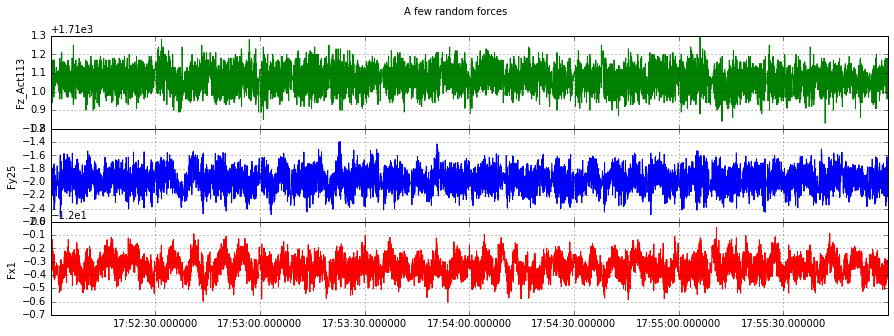

In [7]:
# we check a few forces, see how they varied around that time
# according to Chris. The forces that were added around that time was the last set of bending forces.
# since we are at our last iteration with the optimization. These forces were at the noise level.
fig3, ax3 = plt.subplots(3, sharex=True, figsize = (15,5))
fig3.suptitle('A few random forces')
ax3[2].plot(df1['date_time'], df1['XForces_1'], color='r')
ax3[2].set_ylabel('Fx1')
ax3[2].grid()
ax3[1].plot(df1['date_time'], df1['YForces_25'], color='b')
ax3[1].set_ylabel('Fy25')
ax3[1].grid()
ax3[0].plot(df1['date_time'], df1['ZForces_%d'%sampleIdx], color='g')
ax3[0].set_ylabel('Fz_Act%d'%FATABLE[sampleIdx-1][FATABLE_ID])
ax3[0].grid()
fig3.subplots_adjust(hspace=0)
#ax3[2].xaxis.tick_params(labelrotation=45)
#plt.setp(ax3[2].xaxis.get_majorticklabels(), rotation=45)

### Applied forces vs Measured forces

In [8]:
table_name = 'm1m3_ForceActuatorData'
query = 'select * from {0} where {0}.date_time between \'{1}\' and \'{2}\';'.format(table_name, b1, b2)
print(query)
filename = 'efdData/MeasuredForces_%s.csv'%(b1+(b2-b1)/2).strftime("%y%m%d_%H%M")
if not os.path.isfile(filename):
    dfm = pd.read_sql_query(query, engine1)
    dfm.to_csv(filename)
else:
    print('-------Reading from %s-------------'%filename)
    dfm = pd.read_csv(filename,parse_dates=['date_time']) #make sure dtype for date_time column is understood

select * from m1m3_ForceActuatorData where m1m3_ForceActuatorData.date_time between '2019-01-25 17:52:00' and '2019-01-25 17:56:00';
-------Reading from efdData/MeasuredForces_190125_1754.csv-------------


Text(0.5, 1.0, 'z: Measured - Applied')

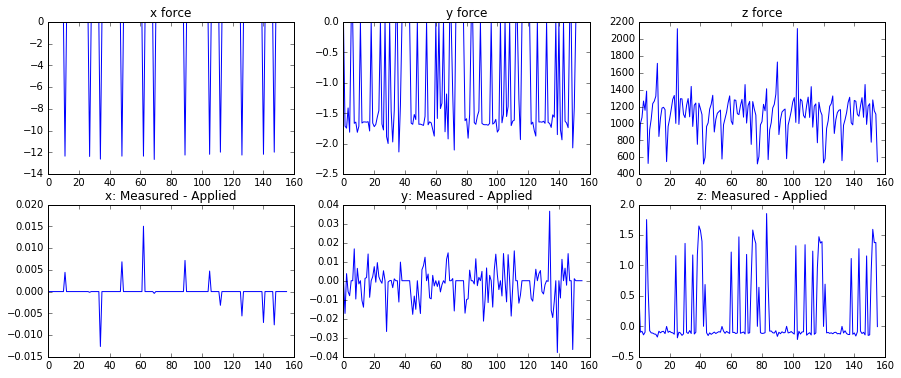

In [9]:
#assemble the force vector for Applied forces
appliedF = assembleFfromEFD(df1)
measuredF = assembleFfromEFD(dfm)
fig, ax = plt.subplots(2,3,figsize=(15,6))
ax[0][0].plot(appliedF[:,1])
ax[0][1].plot(appliedF[:,2])
ax[0][2].plot(appliedF[:,3])
ax[0][0].set_title('x force')
ax[0][1].set_title('y force')
ax[0][2].set_title('z force')

ax[1][0].plot(measuredF[:,1] - appliedF[:, 1])
ax[1][1].plot(measuredF[:,2] - appliedF[:, 2])
ax[1][2].plot(measuredF[:,3] - appliedF[:, 3])
ax[1][0].set_title('x: Measured - Applied')
ax[1][1].set_title('y: Measured - Applied')
ax[1][2].set_title('z: Measured - Applied')

### Get the forces which Chris got from the control computer, so that we can verify EFD forces

In [10]:
dfc = pd.read_csv('data/forces_190125_Chris.csv')
appliedForces = dfc.appliedForces
balanceForces = dfc.balanceForces
staticForces = dfc.staticForces
bendingForces = dfc.bendingForces
initialOptimizedForces = dfc.initialOptimizedForces

Text(0.5, 1.0, 'y forces (N)')

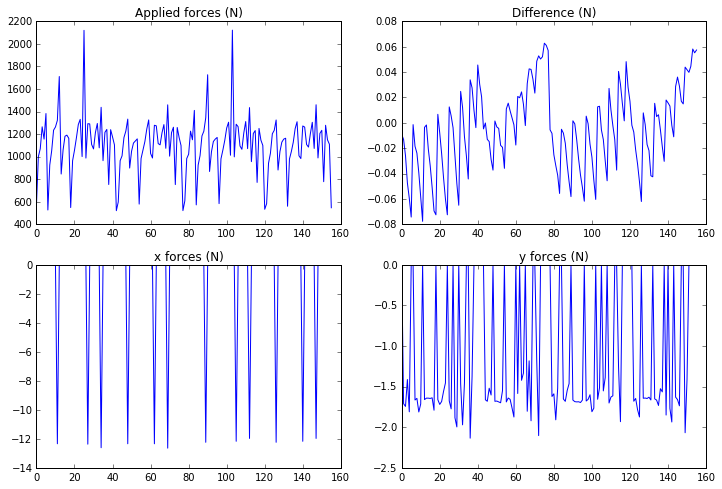

In [11]:
# appliedForces are those from Chris' control computer.
fig, ax = plt.subplots(2,2, figsize=(12,8))
ax[0][1].plot(appliedF[:,3] - appliedForces)
ax[0][0].plot(appliedF[:,3])
ax[0][0].set_title('Applied forces (N)')
ax[0][1].set_title('Difference (N)')
ax[1][0].plot(appliedF[:,1])
ax[1][0].set_title('x forces (N)')
ax[1][1].plot(appliedF[:,2])
ax[1][1].set_title('y forces (N)')

select * from m1m3_logevent_AppliedBalanceForces where m1m3_logevent_AppliedBalanceForces.date_time between '2019-01-25 17:52:00' and '2019-01-25 17:56:00';
-------Reading from efdData/BalanceForces_190125_1754.csv-------------


Text(0.5, 1.0, 'y forces (N)')

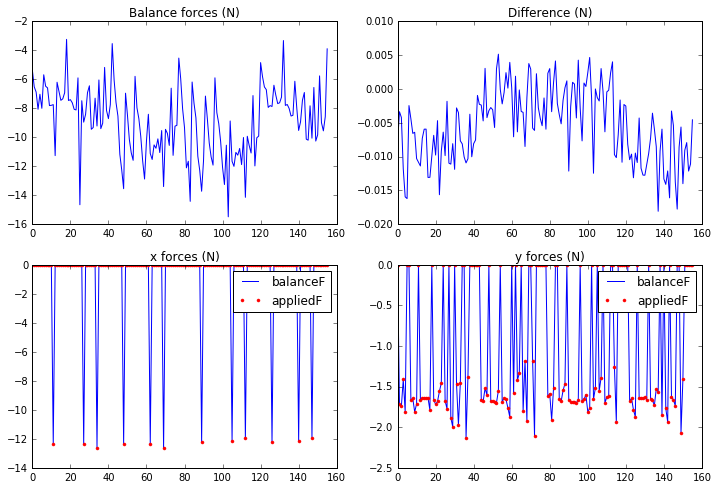

In [12]:
table_name = 'm1m3_logevent_AppliedBalanceForces'
query = 'select * from {0} where {0}.date_time between \'{1}\' and \'{2}\';'.format(table_name, b1, b2)
print(query)
filename = 'efdData/BalanceForces_%s.csv'%(b1+(b2-b1)/2).strftime("%y%m%d_%H%M")
if not os.path.isfile(filename):
    df2 = pd.read_sql_query(query, engine1)
    df2.to_csv(filename)
else:
    print('-------Reading from %s-------------'%filename)
    df2 = pd.read_csv(filename,parse_dates=['date_time']) #make sure dtype for date_time column is understood

balanceF = assembleFfromEFD(df2)
fig, ax = plt.subplots(2,2, figsize=(12,8))
ax[0][1].plot(balanceF[:,3] - balanceForces)
ax[0][0].plot(balanceF[:,3])
ax[0][0].set_title('Balance forces (N)')
ax[0][1].set_title('Difference (N)')
ax[1][0].plot(balanceF[:,1], label='balanceF')
ax[1][0].plot(appliedF[:,1], 'r.',label='appliedF')
ax[1][0].legend()
ax[1][0].set_title('x forces (N)')
ax[1][1].plot(balanceF[:,2], label='balanceF')
ax[1][1].plot(appliedF[:,2], 'r.', label='appliedF')
ax[1][1].legend()
ax[1][1].set_title('y forces (N)')

select * from m1m3_logevent_AppliedStaticForces where m1m3_logevent_AppliedStaticForces.date_time between '2019-01-25 17:52:00' and '2019-01-25 17:56:00';
-------Reading from efdData/StaticForces_190125_1754.csv-------------


Text(0.5, 1.0, 'Difference (N)')

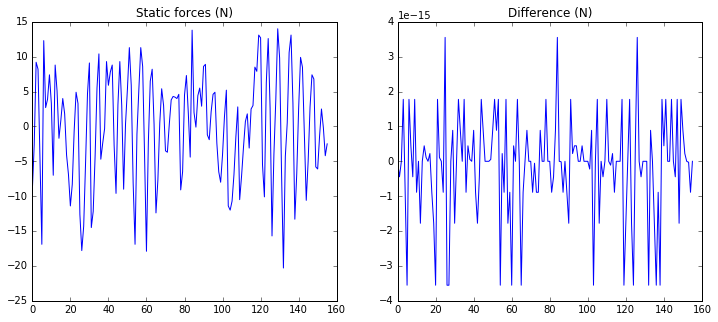

In [13]:
table_name = 'm1m3_logevent_AppliedStaticForces'
query = 'select * from {0} where {0}.date_time between \'{1}\' and \'{2}\';'.format(table_name, b1, b2)
print(query)
filename = 'efdData/StaticForces_%s.csv'%(b1+(b2-b1)/2).strftime("%y%m%d_%H%M")
if not os.path.isfile(filename):
    df3 = pd.read_sql_query(query, engine1)
    df3.to_csv(filename)
else:
    print('-------Reading from %s-------------'%filename)
    df3 = pd.read_csv(filename,parse_dates=['date_time']) #make sure dtype for date_time column is understood

staticF = assembleFfromEFD(df3)
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[1].plot(staticF[:,3] - staticForces)
ax[0].plot(staticF[:,3])
ax[0].set_title('Static forces (N)')
ax[1].set_title('Difference (N)')

select * from m1m3_logevent_AppliedActiveOpticForces where m1m3_logevent_AppliedActiveOpticForces.date_time between '2019-01-25 17:52:00' and '2019-01-25 17:56:00';
-------Reading from efdData/BendingForces_190125_1754.csv-------------
---No XForces---
---No YForces---


Text(0.5, 1.0, 'Difference (N)')

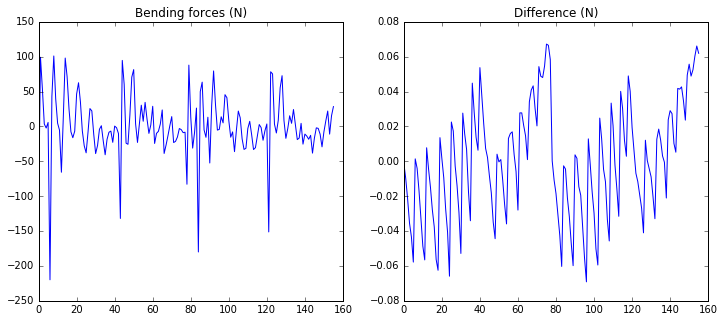

In [16]:
table_name = 'm1m3_logevent_AppliedActiveOpticForces'
query = 'select * from {0} where {0}.date_time between \'{1}\' and \'{2}\';'.format(table_name, b1, b2)
print(query)
filename = 'efdData/BendingForces_%s.csv'%(b1+(b2-b1)/2).strftime("%y%m%d_%H%M")
if not os.path.isfile(filename):
    df4 = pd.read_sql_query(query, engine1)
    df4.to_csv(filename)
else:
    print('-------Reading from %s-------------'%filename)
    df4 = pd.read_csv(filename,parse_dates=['date_time']) #make sure dtype for date_time column is understood

bendingF = assembleFfromEFD(df4)
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[1].plot(bendingF[:,3] - bendingForces)
ax[0].plot(bendingF[:,3])
ax[0].set_title('Bending forces (N)')
ax[1].set_title('Difference (N)')

In [17]:
table_name = 'm1m3_logevent_AppliedCylinderForces'
#What columns are in this table
filename = 'efdData/CylinderForces_column_list1.txt'
if not os.path.isfile(filename):
    fid = open(filename, 'w')
    descr = pd.read_sql_query('describe {}'.format(table_name), engine1)
    for fieldName in descr['Field']:
        print(fieldName)
        fid.write('%s\n'%fieldName)
    fid.close()
else:
    print('-------Reading from %s-------------'%filename)
    fid = open(filename, 'r')
    for line in fid:
        print(line.strip())
    fid.close()     

-------Reading from efdData/CylinderForces_column_list1.txt-------------
date_time
private_revCode
private_sndStamp
private_rcvStamp
private_seqNum
private_origin
private_host
Timestamp
SecondaryCylinderForces_1
SecondaryCylinderForces_2
SecondaryCylinderForces_3
SecondaryCylinderForces_4
SecondaryCylinderForces_5
SecondaryCylinderForces_6
SecondaryCylinderForces_7
SecondaryCylinderForces_8
SecondaryCylinderForces_9
SecondaryCylinderForces_10
SecondaryCylinderForces_11
SecondaryCylinderForces_12
SecondaryCylinderForces_13
SecondaryCylinderForces_14
SecondaryCylinderForces_15
SecondaryCylinderForces_16
SecondaryCylinderForces_17
SecondaryCylinderForces_18
SecondaryCylinderForces_19
SecondaryCylinderForces_20
SecondaryCylinderForces_21
SecondaryCylinderForces_22
SecondaryCylinderForces_23
SecondaryCylinderForces_24
SecondaryCylinderForces_25
SecondaryCylinderForces_26
SecondaryCylinderForces_27
SecondaryCylinderForces_28
SecondaryCylinderForces_29
SecondaryCylinderForces_30
SecondaryCyli

select * from m1m3_logevent_AppliedCylinderForces where m1m3_logevent_AppliedCylinderForces.date_time between '2019-01-25 17:52:00' and '2019-01-25 17:56:00';
-------Reading from efdData/CylinderForces_190125_1754.csv-------------


Text(0.5, 1.0, 'z force diff')

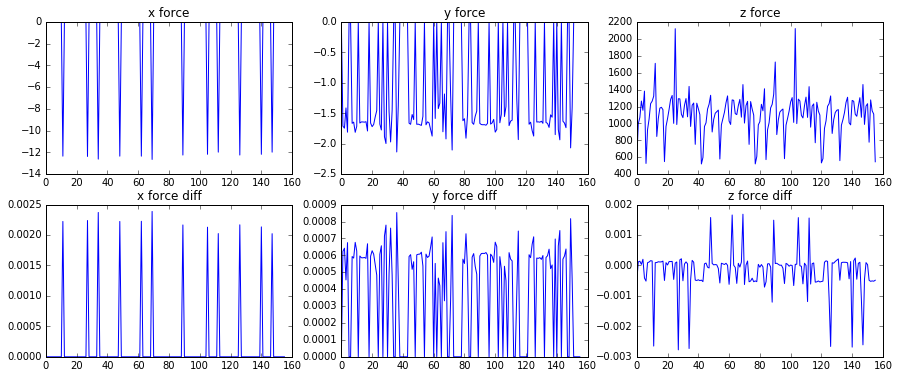

In [18]:
table_name = 'm1m3_logevent_AppliedCylinderForces'
query = 'select * from {0} where {0}.date_time between \'{1}\' and \'{2}\';'.format(table_name, b1, b2)
print(query)
filename = 'efdData/CylinderForces_%s.csv'%(b1+(b2-b1)/2).strftime("%y%m%d_%H%M")
if not os.path.isfile(filename):
    df5 = pd.read_sql_query(query, engine1)
    df5.to_csv(filename)
else:
    print('-------Reading from %s-------------'%filename)
    df5 = pd.read_csv(filename,parse_dates=['date_time']) #make sure dtype for date_time column is understood

appliedF_fromC1C2 = assembleFfromEFD_C1C2(df5)
fig, ax = plt.subplots(2,3,figsize=(15,6))
ax[0][0].plot(appliedF[:,1])
ax[0][1].plot(appliedF[:,2])
ax[0][2].plot(appliedF[:,3])
ax[0][0].set_title('x force')
ax[0][1].set_title('y force')
ax[0][2].set_title('z force')

ax[1][0].plot(appliedF_fromC1C2[:,1] - appliedF[:, 1])
ax[1][1].plot(appliedF_fromC1C2[:,2] - appliedF[:, 2])
ax[1][2].plot(appliedF_fromC1C2[:,3] - appliedF[:, 3])
ax[1][0].set_title('x force diff')
ax[1][1].set_title('y force diff')
ax[1][2].set_title('z force diff')

(-6.0, 6.0, -6.0, 6.0)

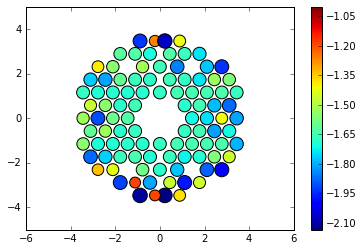

In [19]:
# y forces 2 map
xact = np.float16(fat[:, FATABLE_XPOSITION])
yact = np.float16(fat[:, FATABLE_YPOSITION])
plt.scatter(xact, yact, abs(appliedF[:,2])*1e2, appliedF[:,2], vmax=-1)
plt.colorbar()
plt.axis('equal')
# is this pure noise? 

### We did add addtional forces to the quads

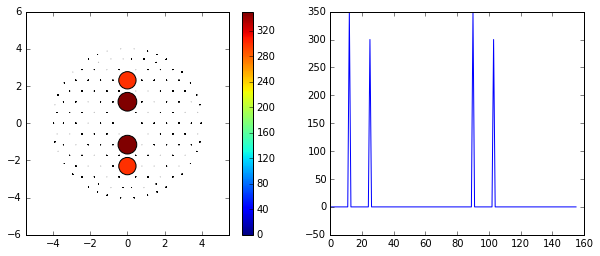

In [20]:
aa = subtractForces(appliedForces, initialOptimizedForces)
aa = subtractForces(aa, balanceForces)
aa = subtractForces(aa, staticForces)
aa = subtractForces(aa, bendingForces)
fquad = np.array(aa)

fig, ax = plt.subplots(1, 2, figsize = (10,4))
img = ax[0].scatter(xact, yact, abs(fquad), fquad)
ax[0].axis('equal')
plt.colorbar(img, ax=ax[0])
ax[1].plot(fquad)

In [21]:
# quad force values
aa= np.sort(fquad)
aa = aa[::-1]
aa[:4]

array([350.  , 349.99, 300.  , 300.  ])

In [22]:
# the missing mass
print(sum(appliedForces), sum(initialOptimizedForces), sum(balanceForces))

172662.59 172741.41999999995 -1379.4099999999992


In [23]:
np.where(actID==113)

(array([12]),)

In [24]:
# how much force did we have on the quads?
print(initialOptimizedForces[np.where(actID==113)[0][0]])
print(appliedForces[np.where(actID==113)[0][0]])

1429.2
1711.07


### A little bit more EFD diagonosis
* sndTime is out of order. If we query using that, it will be very slow.Date_time is actually the insert time, which is not really what we want, but close. Date_time is always in order, because that is the order the data get inserted.
* Note that the clocks between the control computer (which sends sndTime) and EFD computer (which records insert time) are out of sync. That is why sndTime is later, and insert time is earlier. Neither of these is guaranteed to match timestamps for h5 files. Because Mirror Lab data processing computers are another separate set of computers.

In [25]:
b1 = datetime(2019, 2, 15, 16, 52, 0)
b2 = datetime(2019, 2, 15, 17, 0, 0)
query = 'select * from {0} where {0}.date_time between \'{1}\' and \'{2}\';'.format(table_name, b1, b2)
print(query)
ddf = pd.read_sql_query(query, engine2)

select * from m1m3_logevent_AppliedCylinderForces where m1m3_logevent_AppliedCylinderForces.date_time between '2019-02-15 16:52:00' and '2019-02-15 17:00:00';


In [26]:
ddf

,date_time,private_revCode,private_sndStamp,private_rcvStamp,private_seqNum,private_origin,private_host,Timestamp,SecondaryCylinderForces,PrimaryCylinderForces,priority
0,2019-02-15 16:57:14.879923,LSST TES,1.550250e+09,1.550250e+09,537313941,1,1,1.550250e+09,-8643 -8896 -6406 -9393 -8302 -8151 -9407 -866...,569115 973662 1067438 1282778 1181408 1399097 ...,0
1,2019-02-15 16:57:14.901683,LSST TES,1.550250e+09,1.550250e+09,537313959,1,1,1.550250e+09,-8632 -8878 -6463 -9360 -8302 -8155 -9374 -865...,569070 973582 1067326 1282673 1181229 1398891 ...,0
2,2019-02-15 16:57:14.917072,LSST TES,1.550250e+09,1.550250e+09,537313977,1,1,1.550250e+09,-8605 -8831 -6610 -9274 -8301 -8166 -9287 -862...,569084 973602 1067360 1282889 1181300 1399074 ...,0
3,2019-02-15 16:57:14.934698,LSST TES,1.550250e+09,1.550250e+09,537313995,1,1,1.550250e+09,-8577 -8782 -6769 -9184 -8302 -8180 -9196 -859...,569097 973586 1067317 1282973 1181194 1399009 ...,0
4,2019-02-15 16:57:14.954456,LSST TES,1.550250e+09,1.550250e+09,537314013,1,1,1.550250e+09,-8628 -8869 -6494 -9344 -8303 -8158 -9358 -864...,569093 973625 1067392 1282807 1181344 1399064 ...,0
5,2019-02-15 16:57:14.984242,LSST TES,1.550250e+09,1.550250e+09,537314030,1,1,1.550250e+09,-8656 -8919 -6333 -9435 -8302 -8145 -9450 -867...,569088 973629 1067398 1282645 1181352 1398984 ...,0
6,2019-02-15 16:57:14.994637,LSST TES,1.550250e+09,1.550250e+09,537314048,1,1,1.550250e+09,-8650 -8909 -6363 -9417 -8301 -8147 -9432 -867...,569125 973687 1067475 1282790 1181472 1399161 ...,0
7,2019-02-15 16:57:15.114416,LSST TES,1.550250e+09,1.550250e+09,537314155,1,1,1.550250e+09,-8642 -8895 -6398 -9394 -8300 -8148 -9409 -866...,569099 973628 1067386 1282689 1181313 1398966 ...,0
8,2019-02-15 16:57:15.134193,LSST TES,1.550250e+09,1.550250e+09,537314173,1,1,1.550250e+09,-8623 -8863 -6506 -9333 -8300 -8157 -9347 -864...,569104 973642 1067417 1282862 1181389 1399135 ...,0
9,2019-02-15 16:57:15.154218,LSST TES,1.550250e+09,1.550250e+09,537314191,1,1,1.550250e+09,-8608 -8837 -6591 -9285 -8301 -8164 -9298 -862...,569095 973630 1067408 1282948 1181391 1399191 ...,0


(array([737105.70737516, 737105.70737748, 737105.70737979, 737105.70738211,
        737105.70738442]), <a list of 5 Text xticklabel objects>)

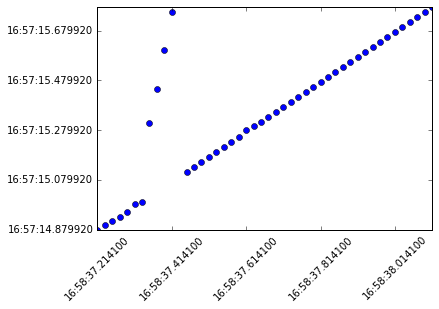

In [27]:
plt.plot(pd.to_datetime(ddf.private_sndStamp[:45], unit='s'), ddf.date_time[:45],'o')
plt.xticks(rotation=45)

In [28]:
datetime.fromtimestamp(1.55e9) #ddf.private_sndStamp[:5])

datetime.datetime(2019, 2, 12, 12, 33, 20)

In [29]:
pd.to_datetime(ddf.private_sndStamp[:5], unit='s')

0   2019-02-15 16:58:37.214106083
1   2019-02-15 16:58:37.234172106
2   2019-02-15 16:58:37.254117965
3   2019-02-15 16:58:37.274238110
4   2019-02-15 16:58:37.294225931
Name: private_sndStamp, dtype: datetime64[ns]

In [30]:
ddf.date_time[:5]

0   2019-02-15 16:57:14.879923
1   2019-02-15 16:57:14.901683
2   2019-02-15 16:57:14.917072
3   2019-02-15 16:57:14.934698
4   2019-02-15 16:57:14.954456
Name: date_time, dtype: datetime64[ns]

In [31]:
initialOptimizedForces_190125 = [707.63,909.78,1014.4,1261.3,1169.1,1401.9,740.2,886.83,953.26,1195.6,1263.3,1342.7,1429.2,834.07,970.52,1116.7,1169.4,1175.5,572.25,985.34,1029.8,1120,1258.1,1340.9,1031.4,1885.7,1020.8,1290.2,1281.9,1122.1,1105.1,1266,1320.1,1089,1462.5,1000.8,1248.6,1261.7,765.11,1261.2,1177,1106.6,525.92,738.75,887.1,952.43,1195.5,1262.6,1339.6,834.87,969.96,1115.8,1167.1,1173.5,571.5,985.41,1029.2,1122.1,1258.1,1340.8,1027.9,1023.2,1293,1284,1122.7,1104.5,1267.8,1322.1,1092,1469.3,1003.4,1249.2,1292.9,770.41,1268.9,1179.9,1113.2,529.68,705.82,910.05,1013.2,1262.4,1168.1,1403,744.67,881.33,954.26,1195.8,1248.5,1343,1432.2,836.69,973.7,1115.4,1170.6,1182.2,570.72,986.36,1028.8,1122,1261.6,1332.9,1025.8,1885.4,1024.4,1288.2,1272.8,1125,1106.6,1263.2,1333.6,1077.1,1460.5,997.37,1249.5,1253.9,773.06,1255.8,1168.2,1102.3,522.03,745.6,880.39,955.42,1194.9,1248.4,1340.4,836.78,975.49,1114.2,1170.7,1180.1,568.58,986.91,1028.8,1122.3,1263.5,1331.7,1023.2,1023.4,1290.3,1275.4,1125.3,1105.6,1263.6,1336.6,1080,1466,999.73,1251.5,1257.7,777.31,1263,1170,1107.8,524.83]

In [32]:
type(initialOptimizedForces[:5])

pandas.core.series.Series

In [33]:
# This was used to write out ChrisData/forces_190125.csv
#aa=np.array([initialOptimizedForces+appliedForces+staticForces+balanceForces+bendingForces]).reshape(5,-1).transpose()
#np.savetxt('ChrisData/forces_190125.csv',aa, delimiter=",", header="initialOptimizedForces,appliedForces,staticForces,balanceForces,bendingForces", 
#           fmt="%.2f", comments='')